# Conformal Prediction - Basic Testing for state action conditioning

Given an expected dataset from a state action-conditioned world model, how will conformal prediction behave?

In [11]:
import numpy as np
from collections import deque

# consider the wm has correctly learned a 30% slip rate transition for a particular state
# state 3,1 - action right
wm = np.zeros(shape=(16,))
wm[4] = 0.14
wm[12] = 0.16
wm[9] = 0.5
# wm[3] = 0.2
# wm[1] = 0.01

wm = wm / wm.sum()

n = 200
alpha = 0.2
# noise_amp = 1e-8
noise_amp = 0
seed = 42

# so here are our world model preds. Let's conformalise now :)
def run_experiment(exp_seed: int, alpha: float, noise_amp: float):
    rng = np.random.default_rng(exp_seed)

    # sample a calibration set
    calib_set = deque(maxlen=n)
    for _ in range(n):
        calib_set.append(rng.choice(range(16), p=wm))

    # now we need to conformalise.
    scores = [1 - wm[i] + noise_amp * rng.random() for i in calib_set]
    q_level = min(1.0, np.ceil((n+1)*(1-alpha))/n)
    qhat = np.quantile(scores, q_level, method='higher')
    prediction_set = np.flatnonzero(wm >= (1 - qhat))

    true_coverage_rate = wm[prediction_set.tolist()].sum()
    return true_coverage_rate

In [12]:
n_runs = 50
n_alphas = 100
alphas = np.linspace(0, 1, n_alphas)

coverages_no_noise = np.zeros((n_alphas, n_runs))
coverages_w_noise = np.zeros((n_alphas, n_runs))
for alpha_ix, alpha in enumerate(alphas):
    for run_seed in range(50):
        coverages_no_noise[alpha_ix, run_seed] = run_experiment(run_seed, alpha, noise_amp=0.0)
        coverages_w_noise[alpha_ix, run_seed] = run_experiment(run_seed, alpha, noise_amp=1e-8)

coverages_no_noise = coverages_no_noise.mean(axis=1)
coverages_w_noise = coverages_w_noise.mean(axis=1)

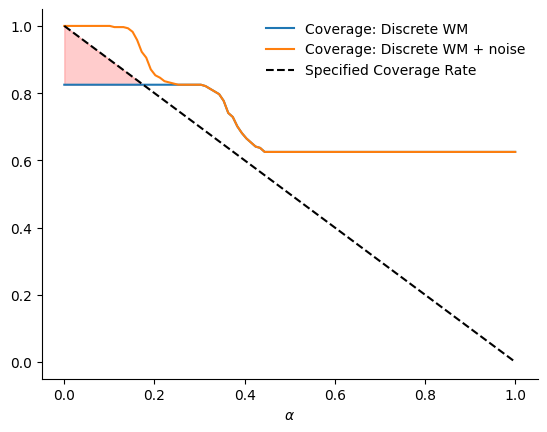

In [13]:
import matplotlib.pyplot as plt
from crl.utils.graphing import despine

plt.plot(alphas, coverages_no_noise, label='Coverage: Discrete WM')
plt.plot(alphas, coverages_w_noise, label='Coverage: Discrete WM + noise')
plt.plot(alphas, 1 - alphas, label='Specified Coverage Rate', linestyle='--', c='k')

start = -1
end = -1
flagged = False
for ix, alpha in enumerate(alphas):
    if (1 - alpha < coverages_no_noise[ix]) and flagged:
        end = ix
        break
    elif 1 - alpha > coverages_no_noise[ix] and not flagged:
        start = ix
        flagged = True

plt.fill_between(alphas[start:end], coverages_no_noise[start:end], 1 - alphas[start:end], color='red', alpha=0.2)
plt.xlabel(r'$\alpha$')
despine(plt.gca())
plt.legend(frameon=False);
# In the red region, conformal prediction DOES NOT HOLD

In [15]:
# plt.scatter(range(50), coverages_no_noise)
# plt.scatter(range(50), coverages_w_noise)
# plt.axhline(y=1-alpha, linestyle='--')
# plt.ylim(0, 1)
# plt.title(f"Observed coverage rates, with calibration set of size {n}")
# despine(plt.gca())
# plt.grid(which='major', axis='y', linestyle='--', alpha=0.6)

Noising works because it induces the quantile calculation to interpolation between discrete values. Note the slopes (here using a large noise amp to exaggerate the effect)

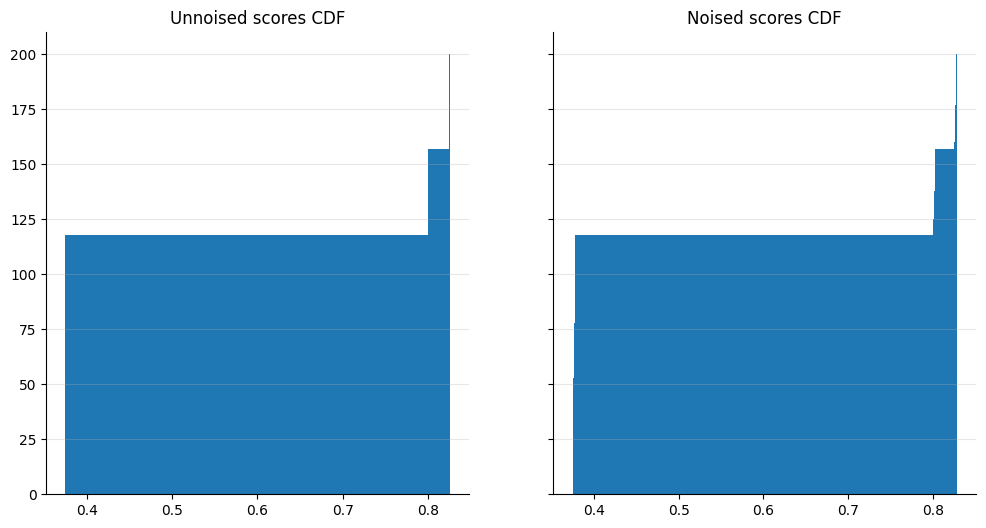

In [26]:
rng = np.random.default_rng(12)

wm = np.zeros(shape=(16,))
wm[4] = 0.14
wm[12] = 0.16
wm[9] = 0.5
wm = wm / wm.sum()

calib_set_no_noise = deque(maxlen=n)
calib_set_w_noise = deque(maxlen=n)
for _ in range(n):
    choice = rng.choice(range(16), p=wm)
    score = 1 - wm[choice]
    calib_set_no_noise.append(score)
    calib_set_w_noise.append(score + 3e-3 * rng.random())

fig, axes = plt.subplots(1, 2, sharey='row', figsize=(12, 6))

axes[0].hist(calib_set_no_noise, density=False, cumulative=True, bins=1000)
axes[1].hist(calib_set_w_noise, density=False, cumulative=True, bins=1000)

[despine(ax) for ax in axes]
axes[0].grid(which='major', axis='y',alpha=0.3)
axes[1].grid(which='major', axis='y',alpha=0.3)

axes[0].set_title('Unnoised scores CDF')
axes[1].set_title('Noised scores CDF')
# axes[0].axvline(9, c='tab:orange', alpha=0.8, linestyle='--')
# axes[1].axvline(9, c='tab:orange', alpha=0.8, linestyle='--')
plt.show()

In [46]:
bin_vals_no_noise, bins_no_noise, _ = plt.hist(calib_set_no_noise, density=True, cumulative=True, bins=1000);
bin_vals_w_noise, bins_w_noise, _ = plt.hist(calib_set_w_noise, density=True, cumulative=True, bins=1000);
plt.close()
print(f'No Noise{bin_vals_no_noise[-10:]}')
print(f'W/ Noise{bin_vals_w_noise[-10:]}')

No Noise[0.785 0.785 0.785 0.785 0.785 0.785 0.785 0.785 0.785 1.   ]
W/ Noise[0.785 0.785 0.785 0.8   0.835 0.87  0.885 0.92  0.96  1.   ]


In [42]:
q_level = 0.95
qhat_no_noise = np.quantile(calib_set_no_noise, q=q_level, method='higher')
qhat_w_noise = np.quantile(calib_set_w_noise, q=q_level, method='higher')

In [43]:
qhat_no_noise, qhat_w_noise

(np.float64(0.825), np.float64(0.8274745737765071))

In [45]:
1 - qhat_no_noise, 1 - qhat_w_noise

(np.float64(0.17500000000000004), np.float64(0.17252542622349287))

In [50]:
0.175 > 1 - qhat_no_noise, 0.175 > 1 - qhat_w_noise

(np.False_, np.True_)